In [11]:
# Numerical computing library (used for arrays, math operations)
import numpy as np

# Data manipulation and analysis (used for CSVs, tables, labels)
import pandas as pd

# Operating system utilities (file paths, directory handling)
import os

# Visualization library (used for plotting graphs like accuracy & loss)
import matplotlib.pyplot as plt

# Core TensorFlow library
import tensorflow as tf

# Keras model APIs
from tensorflow.keras.models import Sequential, Model

# Image preprocessing and data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Optimizer for training neural networks
from tensorflow.keras.optimizers import Adam

# Common neural network layers for CNNs
from tensorflow.keras.layers import (
    Conv2D,                 # Convolution layer for feature extraction
    MaxPooling2D,           # Downsampling layer
    Dense,                  # Fully connected layer
    Dropout,                # Regularization to reduce overfitting
    Flatten,                # Convert feature maps to 1D vector
    GlobalAveragePooling2D, # Reduces spatial dimensions
    BatchNormalization      # Stabilizes and speeds up training
)

# Callbacks to control training process
from tensorflow.keras.callbacks import (
    EarlyStopping,          # Stops training when validation stops improving
    ModelCheckpoint,        # Saves best model during training
    ReduceLROnPlateau       # Reduces learning rate when performance plateaus
)


In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arnabkumarroy02/ferplus")

print("Path to dataset files:", path)

100%|██████████| 487M/487M [00:08<00:00, 62.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arnabkumarroy02/ferplus/versions/3


In [12]:
# List all files and folders inside the main dataset directory
print(os.listdir(path))

# Get list of class folders inside test directory
test_classes = os.listdir(os.path.join(path, "test"))

# Get list of class folders inside train directory
train_classes = os.listdir(os.path.join(path, "train"))

# Print class names in test set
print("Test classes:", test_classes)

# Print class names in train set
print("Train classes:", train_classes)


['train', 'test', 'validation']
Test classes: ['disgust', 'suprise', 'angry', 'happy', 'contempt', 'neutral', 'fear', 'sad']
Train classes: ['disgust', 'suprise', 'angry', 'happy', 'contempt', 'neutral', 'fear', 'sad']


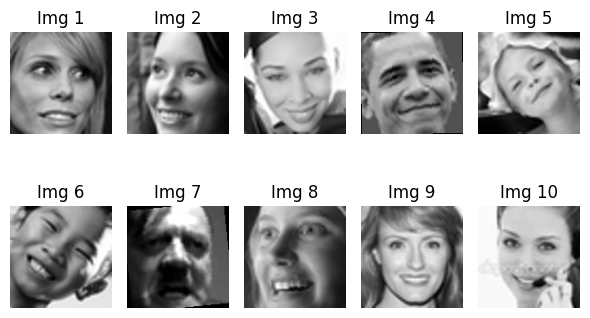

In [13]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to a specific class folder inside training data
# Example structure: path/train/happy/
image_folder = os.path.join(path, "train", "happy")

try:
    # Get list of all files inside the class folder
    files = os.listdir(image_folder)

    # Check if the folder contains images
    if len(files) > 0:
        # Limit visualization to first 10 images
        images_to_show = files[:10]

        # Create a figure for image grid
        plt.figure(figsize=(6, 4))

        for i, image_file in enumerate(images_to_show):
            # Create full image path
            full_path = os.path.join(image_folder, image_file)

            # Open image and convert to grayscale
            img = Image.open(full_path).convert("L")

            # Create subplot (2 rows, 5 columns)
            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap="gray")
            plt.title(f"Img {i + 1}")
            plt.axis("off")

        # Adjust layout to avoid overlapping
        plt.tight_layout()
        plt.show()

    else:
        print("The folder is empty. No images found.")

except Exception as e:
    print("Error while loading images:", e)


In [14]:
# Create path of a single sample image from the 'happy' class
img_path = os.path.join(path, "train", "happy", os.listdir(os.path.join(path, "train", "happy"))[0])

# Open the image using PIL
img = Image.open(img_path)

# Print image resolution (width, height)
print("Image size:", img.size)


Image size: (112, 112)


In [15]:
# ImageDataGenerator for preprocessing and data augmentation
data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,        # Normalize pixel values from [0, 255] to [0, 1]
    rotation_range=10,          # Randomly rotate images by up to 10 degrees
    width_shift_range=0.2,      # Randomly shift images horizontally
    height_shift_range=0.2,     # Randomly shift images vertically
    shear_range=0.2,            # Apply shear transformation
    zoom_range=0.2,             # Randomly zoom in/out
    horizontal_flip=True        # Randomly flip images horizontally
)


In [16]:
# Load training data from directory using ImageDataGenerator
train_data = data_gen.flow_from_directory(
    directory=os.path.join(path, "train"),   # Path to training dataset
    target_size=(48, 48),                     # Resize images to 48x48
    color_mode="grayscale",                   # Load images in grayscale
    batch_size=64,                            # Number of images per batch
    class_mode="categorical",                 # One-hot encoded labels
    shuffle=True                              # Shuffle data for better training
)


Found 66379 images belonging to 8 classes.


In [17]:
# Load test data from directory (NO data augmentation should be applied)
test_data = data_gen.flow_from_directory(
    directory=os.path.join(path, "test"),   # Path to test dataset
    target_size=(48, 48),                    # Resize images to 48x48
    color_mode="grayscale",                  # Load images in grayscale
    batch_size=64,                           # Number of images per batch
    class_mode="categorical",                # One-hot encoded labels
    shuffle=False                            # Keep order for evaluation
)


Found 3573 images belonging to 8 classes.


In [21]:
# Load validation data from directory
val_data = data_gen.flow_from_directory(
    directory=os.path.join(path, "validation"),  # Validation folder
    target_size=(48, 48),                    # Resize images
    color_mode="grayscale",                  # Grayscale images
    batch_size=64,                           # Batch size
    class_mode="categorical",                # One-hot encoded labels
    shuffle=False                            # Keep order consistent
)


Found 8341 images belonging to 8 classes.


In [22]:
# Fetch a single batch of images and labels from the training generator
batch = next(train_data)

# Unpack images and corresponding labels
images, labels = batch

# Print the shape of image batch
print("Images shape:", images.shape)


Images shape: (64, 48, 48, 1)


In [23]:
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(48, 48, 1)),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    Conv2D(128, (3, 3), padding="same", activation="relu"),

    BatchNormalization(),       # Normalize activations
    MaxPooling2D(2, 2),         # Reduce spatial dimensions
    Dropout(0.25),              # Prevent overfitting

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    Conv2D(512, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(2, 2),
    Dropout(0.5),

    Flatten(),                  # Flatten feature maps to feed Dense layers

    # Fully connected layers
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dropout(0.2),
    Dense(256, activation="relu"),

    Dense(8, activation="softmax")  # Output layer for 8 classes

    ])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
Adam = Adam(learning_rate=0.0001)

In [ ]:
# We need to compile the model before training
# - optimizer: Adam (adaptive learning rate optimizer, widely used for CNNs)
# - loss: categorical_crossentropy (used for multi-class classification)
# - metrics: accuracy (we want to track how often predictions match labels)

model.compile(
    optimizer=Adam(),                # Make sure to call Adam() as a function
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("Model compiled successfully!")


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 24, 24, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    75,498,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,725,192 (296.50 MB)

 Trainable params: 77,724,936 (296.50 MB)

 Non-trainable params: 256 (1.00 KB)

In [24]:
# Class weights help to handle imbalanced datasets.
# If some classes have fewer images, the model will give them more importance during training.

from sklearn.utils import class_weight
import numpy as np

# Extract class labels from the training data
labels = train_data.classes

# Compute balanced class weights automatically
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",      # Automatically adjust weights inversely proportional to class frequencies
    classes=np.unique(labels),    # Unique class labels
    y=labels                      # Actual labels from training data
)

# Convert to dictionary format for Keras
class_weight_dict = dict(enumerate(class_weights))

# Display class weights
print("Class weights:", class_weight_dict)


Class weights: {0: np.float64(1.037171875), 1: np.float64(1.037171875), 2: np.float64(1.037171875), 3: np.float64(1.037171875), 4: np.float64(1.037171875), 5: np.float64(0.7994387705944695), 6: np.float64(1.037171875), 7: np.float64(1.037171875)}


In [25]:
# EarlyStopping stops training when the monitored metric stops improving.
# This helps prevent overfitting and saves training time.

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",       # Monitor validation loss
    patience=5,               # Stop training if no improvement for 5 consecutive epochs
    verbose=1,                # Print message when stopping
    restore_best_weights=True # Restore model weights from the epoch with the best validation loss
)

print("EarlyStopping callback created successfully!")


EarlyStopping callback created successfully!


In [26]:
# ModelCheckpoint saves the model during training whenever the monitored metric improves.
# This ensures we keep the best version of the model based on validation accuracy.

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "NEW_FRE_Model.h5",     # File path to save the best model
    monitor="val_accuracy",  # Metric to monitor
    save_best_only=True,     # Save only when there is improvement
    verbose=1                # Print message when saving
)

print("ModelCheckpoint callback created successfully!")


ModelCheckpoint callback created successfully!


In [27]:
# ReduceLROnPlateau reduces the learning rate when the monitored metric stops improving.
# This helps the model converge better and avoid getting stuck in local minima.

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",   # Metric to monitor
    factor=0.2,           # Reduce learning rate by this factor
    patience=2,           # Number of epochs with no improvement before reducing LR
    verbose=1,            # Print message when learning rate is reduced
    min_lr=1e-5           # Minimum learning rate allowed
)

print("ReduceLROnPlateau callback created successfully!")


ReduceLROnPlateau callback created successfully!


In [ ]:
# Fit the model on the training data
# - Uses validation data to monitor performance
# - Includes class weights to handle imbalanced classes
# - Uses callbacks to improve training and prevent overfitting

history = model.fit(
    train_data,                  # Training dataset
    validation_data=val_data,    # Validation dataset
    epochs=30,                   # Maximum number of epochs
    class_weight=class_weight_dict,  # Handle class imbalance
    verbose=1,                   # Show training progress
    callbacks=[early_stop, checkpoint, reduce_lr]  # Callbacks for checkpoint, early stopping, LR reduction
)

print("Model training complete!")


Epoch 1/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5188 - loss: 1.3046
Epoch 1: val_accuracy improved from 0.45320 to 0.60084, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 206s 199ms/step - accuracy: 0.5189 - loss: 1.3045 - val_accuracy: 0.6008 - val_loss: 1.0947 - learning_rate: 1.0000e-04
Epoch 2/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.5701 - loss: 1.1736
Epoch 2: val_accuracy improved from 0.60084 to 0.64651, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 207s 200ms/step - accuracy: 0.5701 - loss: 1.1736 - val_accuracy: 0.6465 - val_loss: 0.9635 - learning_rate: 1.0000e-04
Epoch 3/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6019 - loss: 1.0917
Epoch 3: val_accuracy improved from 0.64651 to 0.66839, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 207s 199ms/step - accuracy: 0.6019 - loss: 1.0916 - val_accuracy: 0.6684 - val_loss: 0.9105 - learning_rate: 1.0000e-04
Epoch 4/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6384 - loss: 0.9980
Epoch 4: val_accuracy improved from 0.66839 to 0.68421, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 207s 200ms/step - accuracy: 0.6384 - loss: 0.9980 - val_accuracy: 0.6842 - val_loss: 0.8626 - learning_rate: 1.0000e-04
Epoch 5/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6556 - loss: 0.9507
Epoch 5: val_accuracy improved from 0.68421 to 0.71431, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 205s 197ms/step - accuracy: 0.6556 - loss: 0.9507 - val_accuracy: 0.7143 - val_loss: 0.7827 - learning_rate: 1.0000e-04
Epoch 6/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.6684 - loss: 0.9043
Epoch 6: val_accuracy improved from 0.71431 to 0.73791, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 214s 206ms/step - accuracy: 0.6684 - loss: 0.9042 - val_accuracy: 0.7379 - val_loss: 0.7267 - learning_rate: 1.0000e-04
Epoch 7/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6866 - loss: 0.8578
Epoch 7: val_accuracy improved from 0.73791 to 0.74703, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 208s 200ms/step - accuracy: 0.6866 - loss: 0.8578 - val_accuracy: 0.7470 - val_loss: 0.6937 - learning_rate: 1.0000e-04
Epoch 8/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7003 - loss: 0.8184
Epoch 8: val_accuracy improved from 0.74703 to 0.75926, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 213s 205ms/step - accuracy: 0.7003 - loss: 0.8184 - val_accuracy: 0.7593 - val_loss: 0.6664 - learning_rate: 1.0000e-04
Epoch 9/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7154 - loss: 0.7775
Epoch 9: val_accuracy improved from 0.75926 to 0.77876, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 208s 200ms/step - accuracy: 0.7154 - loss: 0.7775 - val_accuracy: 0.7788 - val_loss: 0.6134 - learning_rate: 1.0000e-04
Epoch 10/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7283 - loss: 0.7410
Epoch 10: val_accuracy improved from 0.77876 to 0.78942, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 210s 202ms/step - accuracy: 0.7283 - loss: 0.7410 - val_accuracy: 0.7894 - val_loss: 0.5814 - learning_rate: 1.0000e-04
Epoch 11/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7362 - loss: 0.7151
Epoch 11: val_accuracy did not improve from 0.78942
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 194s 187ms/step - accuracy: 0.7362 - loss: 0.7151 - val_accuracy: 0.7868 - val_loss: 0.5841 - learning_rate: 1.0000e-04
Epoch 12/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7407 - loss: 0.7070
Epoch 12: val_accuracy improved from 0.78942 to 0.80554, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 202s 195ms/step - accuracy: 0.7407 - loss: 0.7069 - val_accuracy: 0.8055 - val_loss: 0.5358 - learning_rate: 1.0000e-04
Epoch 13/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7551 - loss: 0.6720
Epoch 13: val_accuracy improved from 0.80554 to 0.81176, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 207s 199ms/step - accuracy: 0.7551 - loss: 0.6720 - val_accuracy: 0.8118 - val_loss: 0.5172 - learning_rate: 1.0000e-04
Epoch 14/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7573 - loss: 0.6594
Epoch 14: val_accuracy did not improve from 0.81176
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 198s 191ms/step - accuracy: 0.7573 - loss: 0.6594 - val_accuracy: 0.8092 - val_loss: 0.5241 - learning_rate: 1.0000e-04
Epoch 15/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.7634 - loss: 0.6439
Epoch 15: val_accuracy improved from 0.81176 to 0.81860, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 201s 194ms/step - accuracy: 0.7634 - loss: 0.6439 - val_accuracy: 0.8186 - val_loss: 0.5043 - learning_rate: 1.0000e-04
Epoch 16/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.7703 - loss: 0.6223
Epoch 16: val_accuracy improved from 0.81860 to 0.82262, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 205s 197ms/step - accuracy: 0.7703 - loss: 0.6223 - val_accuracy: 0.8226 - val_loss: 0.4852 - learning_rate: 1.0000e-04
Epoch 17/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7760 - loss: 0.6018
Epoch 17: val_accuracy did not improve from 0.82262
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 197s 189ms/step - accuracy: 0.7760 - loss: 0.6018 - val_accuracy: 0.8225 - val_loss: 0.4867 - learning_rate: 1.0000e-04
Epoch 18/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7796 - loss: 0.5941
Epoch 18: val_accuracy improved from 0.82262 to 0.82680, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 209s 201ms/step - accuracy: 0.7796 - loss: 0.5941 - val_accuracy: 0.8268 - val_loss: 0.4696 - learning_rate: 1.0000e-04
Epoch 19/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7845 - loss: 0.5831
Epoch 19: val_accuracy improved from 0.82680 to 0.83585, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 221s 213ms/step - accuracy: 0.7845 - loss: 0.5831 - val_accuracy: 0.8359 - val_loss: 0.4473 - learning_rate: 1.0000e-04
Epoch 20/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7831 - loss: 0.5761
Epoch 20: val_accuracy improved from 0.83585 to 0.83698, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 208s 201ms/step - accuracy: 0.7831 - loss: 0.5761 - val_accuracy: 0.8370 - val_loss: 0.4454 - learning_rate: 1.0000e-04
Epoch 21/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.7929 - loss: 0.5565
Epoch 21: val_accuracy improved from 0.83698 to 0.84769, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 208s 200ms/step - accuracy: 0.7929 - loss: 0.5565 - val_accuracy: 0.8477 - val_loss: 0.4238 - learning_rate: 1.0000e-04
Epoch 22/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.7952 - loss: 0.5491
Epoch 22: val_accuracy did not improve from 0.84769
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 195s 188ms/step - accuracy: 0.7952 - loss: 0.5491 - val_accuracy: 0.8333 - val_loss: 0.4541 - learning_rate: 1.0000e-04
Epoch 23/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7989 - loss: 0.5449
Epoch 23: val_accuracy improved from 0.84769 to 0.85476, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 202s 194ms/step - accuracy: 0.7989 - loss: 0.5449 - val_accuracy: 0.8548 - val_loss: 0.4073 - learning_rate: 1.0000e-04
Epoch 24/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8014 - loss: 0.5353
Epoch 24: val_accuracy improved from 0.85476 to 0.85507, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 205s 198ms/step - accuracy: 0.8014 - loss: 0.5353 - val_accuracy: 0.8551 - val_loss: 0.3968 - learning_rate: 1.0000e-04
Epoch 25/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8072 - loss: 0.5166
Epoch 25: val_accuracy did not improve from 0.85507
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 195s 188ms/step - accuracy: 0.8072 - loss: 0.5166 - val_accuracy: 0.8551 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 26/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8098 - loss: 0.5137
Epoch 26: val_accuracy improved from 0.85507 to 0.85634, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 202s 195ms/step - accuracy: 0.8098 - loss: 0.5137 - val_accuracy: 0.8563 - val_loss: 0.3924 - learning_rate: 1.0000e-04
Epoch 27/30
1038/1038 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8122 - loss: 0.5057
Epoch 27: val_accuracy improved from 0.85634 to 0.86199, saving model to NEW_FRE_Model.h5


1038/1038 ━━━━━━━━━━━━━━━━━━━━ 206s 199ms/step - accuracy: 0.8122 - loss: 0.5057 - val_accuracy: 0.8620 - val_loss: 0.3789 - learning_rate: 1.0000e-04
Epoch 28/30
 174/1038 ━━━━━━━━━━━━━━━━━━━━ 1:30 104ms/step - accuracy: 0.8140 - loss: 0.4946

KeyboardInterrupt: 

In [ ]:
# Evaluate the trained model on the test dataset
# This gives the final performance metrics: loss and accuracy

test_loss, test_acc = model.evaluate(test_data, verbose=1)

print("Test Accuracy :", test_acc)   # Accuracy on test set
print("Test Loss     :", test_loss)  # Loss on test set


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.7455 - loss: 0.7914
Accuracy :  0.7478309273719788
Loss :  0.7478309273719788


In [ ]:
# -------------------------------
# Step 17: Confusion Matrix Values Only
# -------------------------------

import numpy as np
from sklearn.metrics import confusion_matrix

# Predict on test data
y_pred_prob = model.predict(test_data)       # Model probabilities
y_pred = np.argmax(y_pred_prob, axis=1)     # Convert to class indices

y_true = test_data.classes                  # True labels from test data

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print confusion matrix
print("Confusion Matrix (Test Data):")
print(cm)


In [ ]:
import pickle

# Define configuration dictionary
config = {
    "epochs": 30,
    "batch_size": 64,
    "learning_rate": 0.0001
}

# Save configuration to a file using pickle
with open("config.pkl", "wb") as f:
    pickle.dump(config, f)

print("Training configuration saved successfully as 'config.pkl'")


In [ ]:
import json

# Save the class weights dictionary to a JSON file
with open("class_weights.json", "w") as f:
    json.dump(class_weight_dict, f)

print("Class weights saved successfully as 'class_weights.json'")


Saving Screenshot 2025-12-31 141020.png to Screenshot 2025-12-31 141020.png


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step


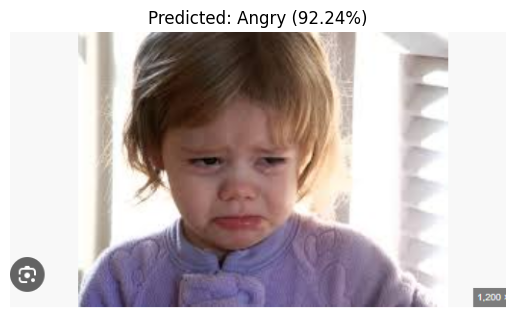

I am 92.24% sure that this is Angry


In [7]:
import numpy as np
import cv2
from google.colab import files
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
# Ensure the path matches your saved model location
model = load_model('Your Model Path')

# Define class labels in alphabetical order
classes = ["Angry", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Upload an image from local system
uploaded = files.upload()  # Colab allows uploading files

for fn in uploaded.keys():
    # Load image in grayscale (as model was trained on grayscale images)
    # Resize to target size 48x48 as per training
    img = image.load_img(fn, target_size=(48, 48), color_mode="grayscale")

    # Convert image to array and preprocess
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension: (1, 48, 48, 1)
    img_array /= 255.0  # Normalize pixel values (same as training)

    # Make prediction
    prediction = model.predict(img_array)
    max_index = np.argmax(prediction[0])  # Index of highest probability
    result = classes[max_index]           # Corresponding class label
    confidence = prediction[0][max_index] * 100  # Confidence in percentage

    # Display the original image with predicted label
    plt.imshow(image.load_img(fn))  # Show original image
    plt.title(f"Predicted: {result} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    print(f"I am {confidence:.2f}% sure that this is {result}")
